In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960

DATA_SOURCE_MAPPING = 'cic-iot-2023:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3512311%2F6126678%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240422%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240422T124935Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D93a81cbb1fd256c37bbb23c6e1ab36e76fe856760d4d0d48d3162ea0e923af59221bc4f7e5277059ba3db218ebe51edadaab262c1ea824c05902fd0623e10c558555283aff8902b6ef42c2a1e1363d32992785132f0c3d526d386ae5b111d0a110793cfcb232ebf48e4aa8ece7127a53ead0ec58151d3b7ba8b6b2e3cd1445bb05b9683827906821ebc8c354832ea7d3f3def8fb62804d8ea7fe03bd680093aef164889ea78941216de641eaf8b5cab13c1bb276d1fef929d0582670f1fa69d121a99ca44fc744850d8a529315af8dcfc74bb48fb91dab8630377709377872ece3a87b90aafd1596a1c8a10881ae8b0c09d856c8eeca1f1ef6eeaf0b34ba29ec'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2977179250 bytes downloaded
Downloaded and uncompressed: cic-iot-2023
Data source import complete.


In [ ]:
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
# importing required libraries for normalizing data
from sklearn.preprocessing import StandardScaler,LabelBinarizer,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, MaxPool1D, Flatten, Dropout,Conv1D , BatchNormalization,Input
from keras.models import Sequential,Model # importing dense layer
# representation of model layers
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Khởi tạo một list rỗng để lưu các DataFrame
dfs = []

# Duyệt qua các file CSV và đọc chúng vào các DataFrame
for i in range(0,3):
    filename = f"/kaggle/input/cic-iot-2023/part-0000{i}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv"
    if i >=10 :
        filename = f"/kaggle/input/cic-iot-2023/part-000{i}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv"
    # Dữ liệu mới để test
    df_test = pd.read_csv("/kaggle/input/cic-iot-2023/part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv")
    df = pd.read_csv(filename)
    dfs.append(df)
# Ghép các DataFrame thành một DataFrame lớn
df = pd.concat(dfs)
labels_to_remove = ['DictionaryBruteForce', 'BrowserHijacking', 'XSS', 'Uploading_Attack', 'SqlInjection', 'CommandInjection', 'Backdoor_Malware']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732750 entries, 0 to 275257
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    732750 non-null  float64
 1   Header_Length    732750 non-null  float64
 2   Protocol Type    732750 non-null  float64
 3   Duration         732750 non-null  float64
 4   Rate             732750 non-null  float64
 5   Srate            732750 non-null  float64
 6   Drate            732750 non-null  float64
 7   fin_flag_number  732750 non-null  float64
 8   syn_flag_number  732750 non-null  float64
 9   rst_flag_number  732750 non-null  float64
 10  psh_flag_number  732750 non-null  float64
 11  ack_flag_number  732750 non-null  float64
 12  ece_flag_number  732750 non-null  float64
 13  cwr_flag_number  732750 non-null  float64
 14  ack_count        732750 non-null  float64
 15  syn_count        732750 non-null  float64
 16  fin_count        732750 non-null  float64
 

<ipython-input-7-5e148818676c>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["label"].value_counts().index, rotation=45, ha='right')


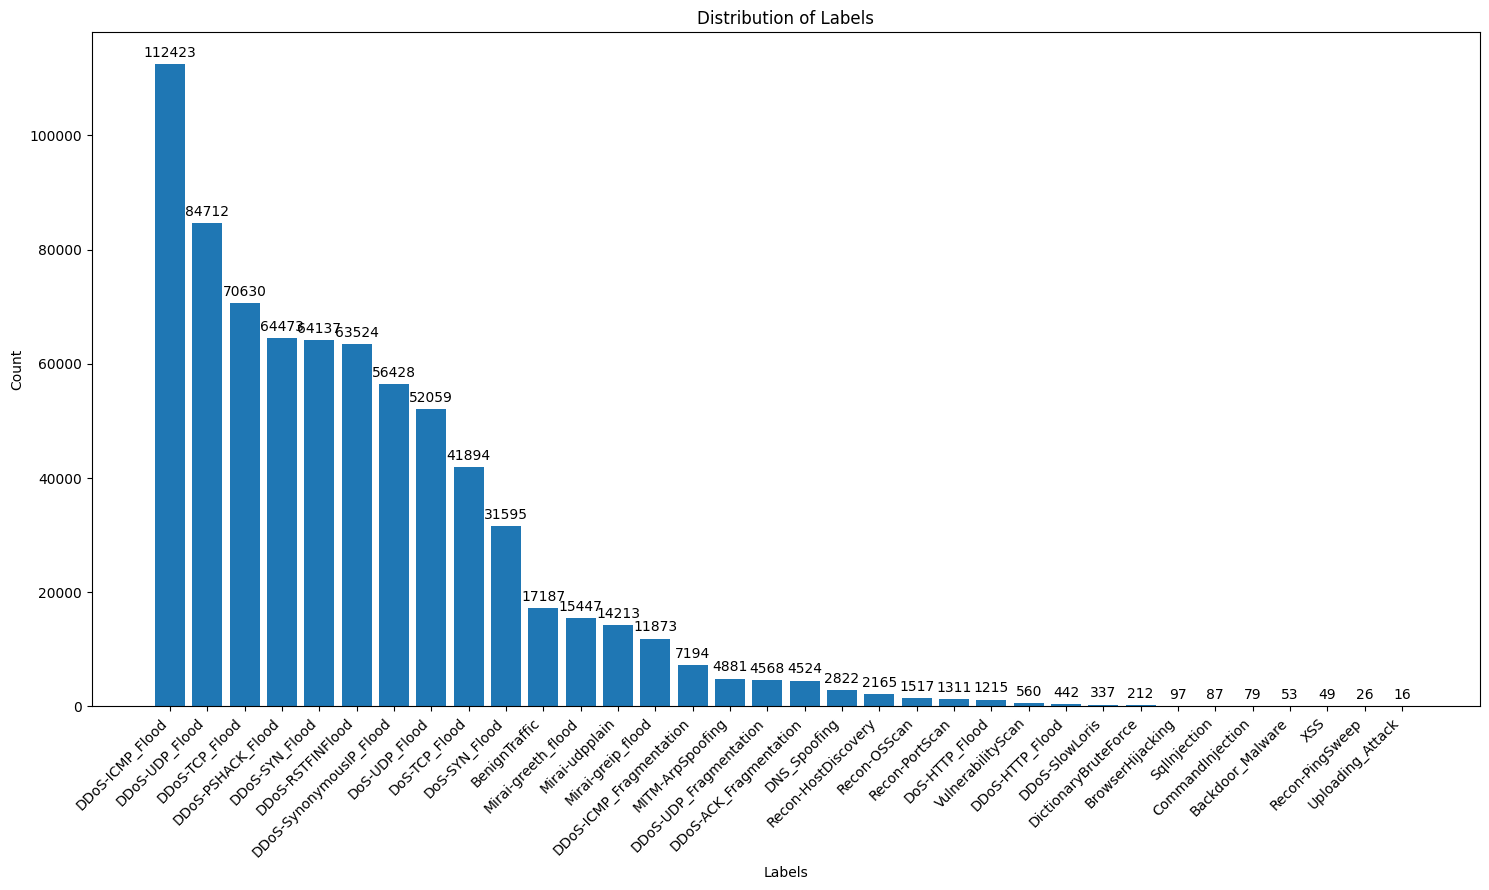

In [ ]:
# Tạo biểu đồ cột
fig, ax = plt.subplots(figsize=(15, 9))
bars = ax.bar(df["label"].value_counts().index, df["label"].value_counts().values, width=0.8)

# Xoay nhãn trên trục x
ax.set_xticklabels(df["label"].value_counts().index, rotation=45, ha='right')

# Định dạng số trên trục y
ax.yaxis.set_major_formatter('{:.0f}'.format)

# Thêm nhãn và tiêu đề
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Labels')

# Hiển thị số liệu chính xác trên đầu mỗi cột
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

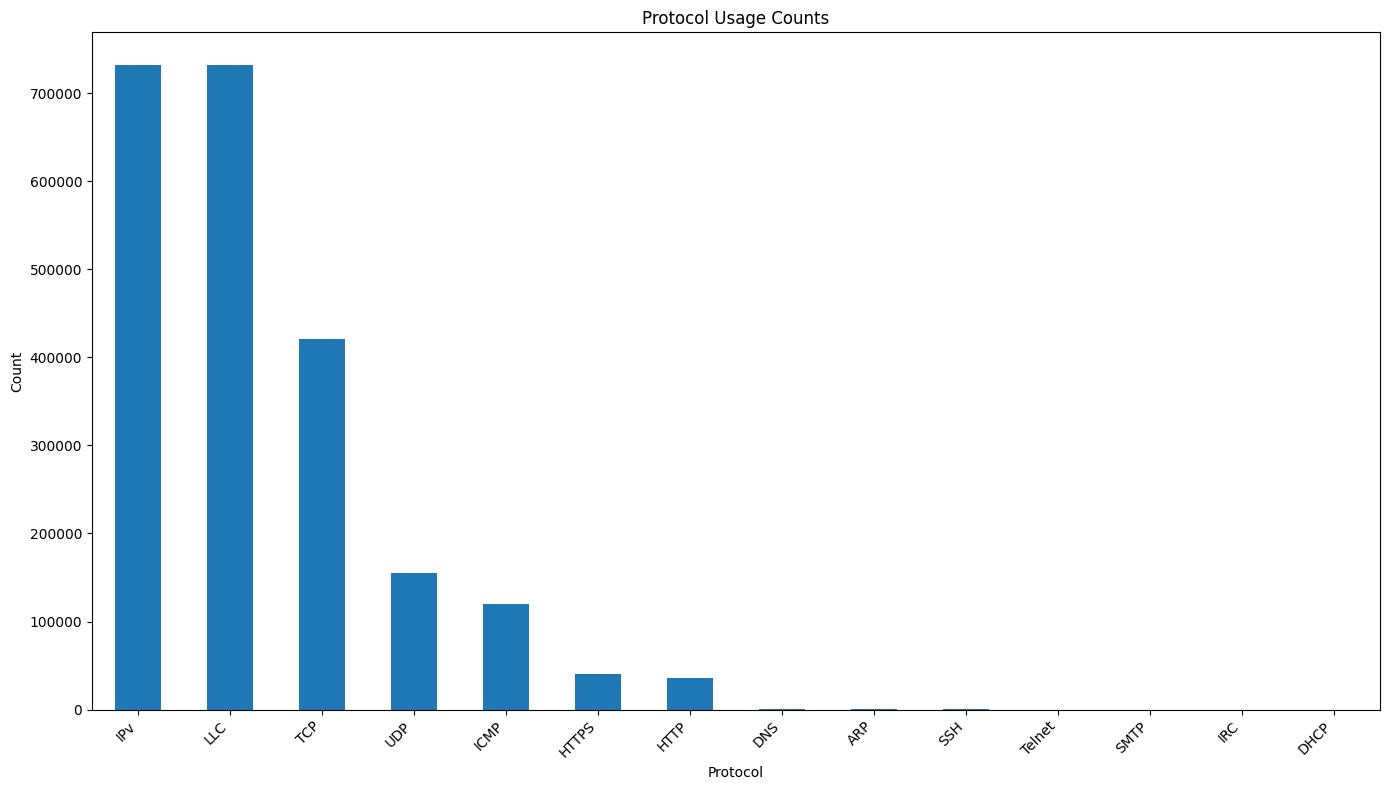

In [ ]:
protocols = ['HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']
protocol_counts = df[protocols].sum().sort_values(ascending=False)

# Now let's plot the protocol usage
plt.figure(figsize=(14, 8))
protocol_counts.plot(kind='bar')
plt.title('Protocol Usage Counts')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better fit
plt.tight_layout()  # Adjust layout
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from pathlib import Path
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


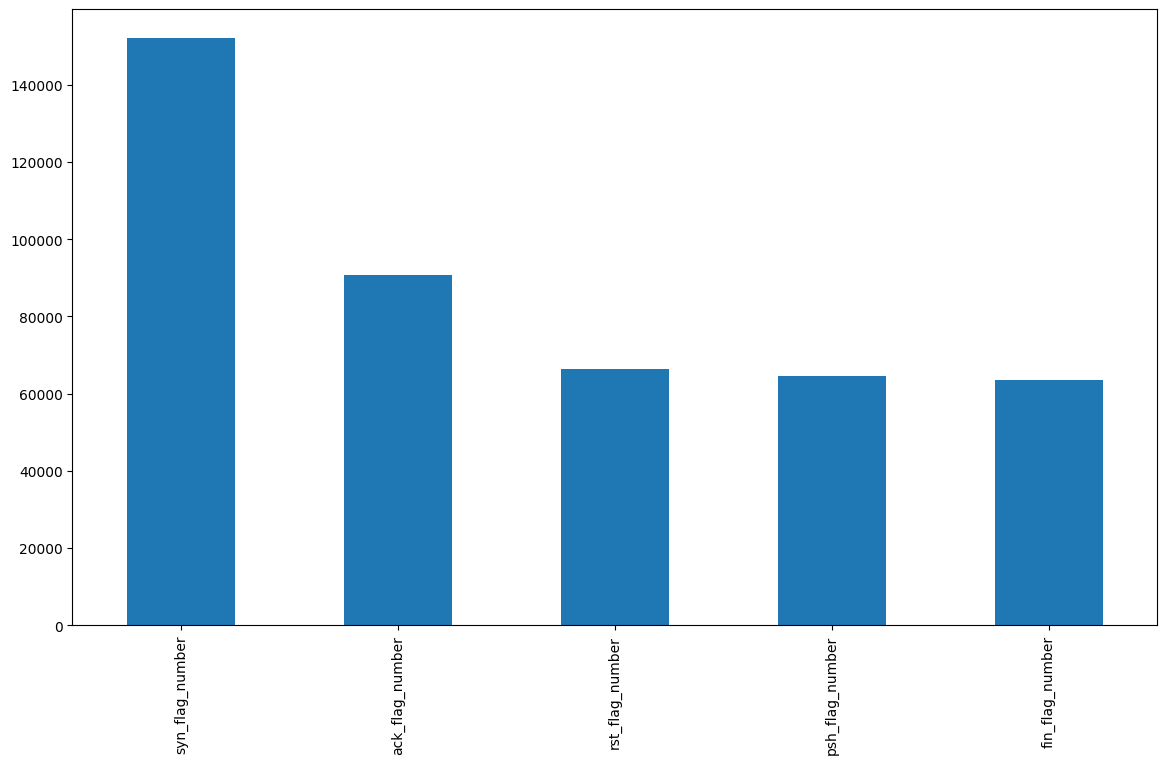

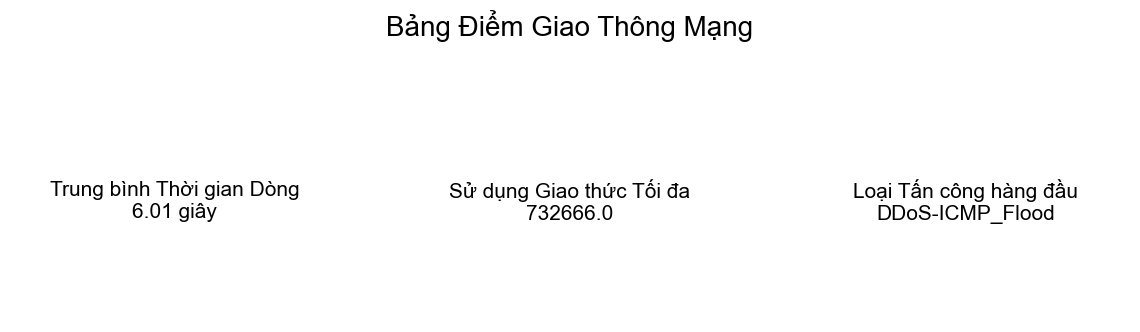

<ipython-input-29-88b9b1f1ba74>:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: Image size of 3193x70247639 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x600 with 1 Axes>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Set up the figure size for the first plot
plt.figure(figsize=(14, 8))
flags = ['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number']
df_flags = df[flags].sum().sort_values(ascending=False)
df_flags.plot(kind='bar')

# Set up the font for Vietnamese characters
font_path = "/content/drive/MyDrive/Arial.ttf"
custom_font = FontProperties(fname=font_path)

# Example metrics for the scorecard
average_flow_duration = df['flow_duration'].mean()
max_protocol_usage = df[protocols].sum().max()
top_attack_type = df['label'].value_counts().idxmax()

# Create the figure and subplots for the scorecard
fig, axs = plt.subplots(1, 3, figsize=(14, 4))  # Adjusted figure size
fig.suptitle('Bảng Điểm Giao Thông Mạng', fontsize=20, fontproperties=custom_font)

# Scorecard for Average Flow Duration
axs[0].text(0.5, 0.5, f'Trung bình Thời gian Dòng\n{average_flow_duration:.2f} giây', fontsize=15,
            ha='center', va='center', fontproperties=custom_font)
axs[0].set_axis_off()

# Scorecard for Max Protocol Usage
axs[1].text(0.5, 0.5, f'Sử dụng Giao thức Tối đa\n{max_protocol_usage}', fontsize=15,
            ha='center', va='center', fontproperties=custom_font)
axs[1].set_axis_off()

# Scorecard for Top Attack Type
axs[2].text(0.5, 0.5, f'Loại Tấn công hàng đầu\n{top_attack_type}', fontsize=15,
            ha='center', va='center', fontproperties=custom_font)
axs[2].set_axis_off()

# Adjust the layout manually to avoid the warning
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)

# Show the figure with the scorecard
plt.show()

# Plot the second figure for sum of flags
plt.figure(figsize=(10, 6))
plt.title('Sum of Flags as Potential Vulnerability Indicators')
plt.xlabel('Flag Type')
plt.ylabel('Sum')
for index, value in enumerate(df_flags):
    plt.text(index, value, f'{value:.0f}', ha='center', va='bottom')  # Add text labels on bars
plt.tight_layout()
plt.show()


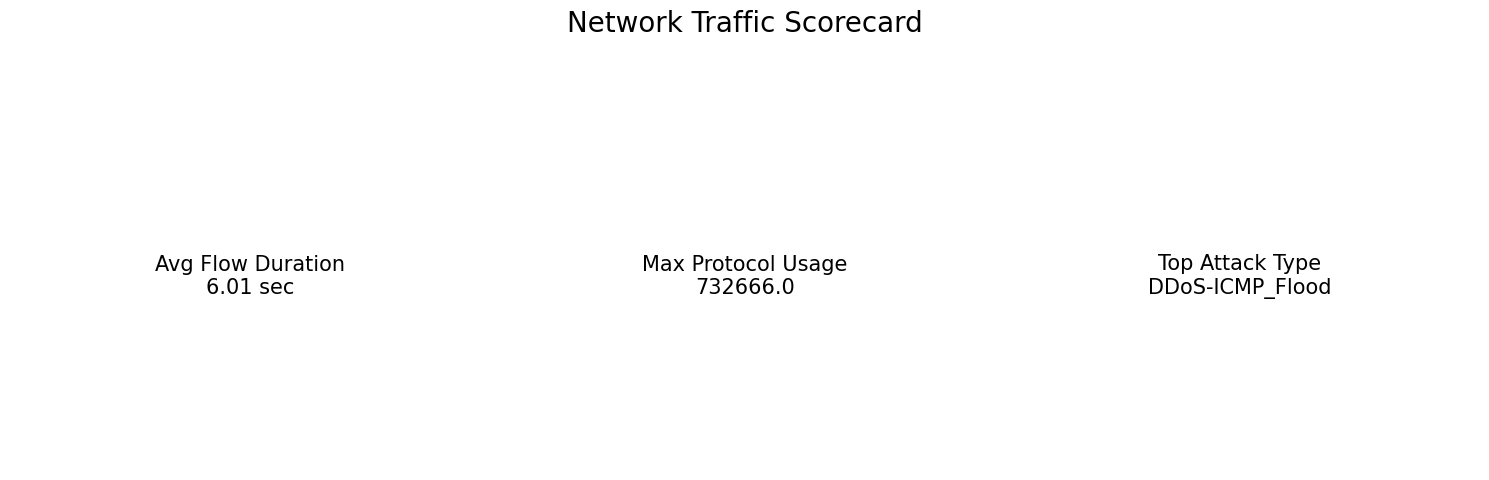

In [ ]:
# Example metrics for the scorecard
average_flow_duration = df['flow_duration'].mean()
max_protocol_usage = df[protocols].sum().max()
top_attack_type = df['label'].value_counts().idxmax()

# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Network Traffic Scorecard', fontsize=20)

# Scorecard for Average Flow Duration
axs[0].text(0.5, 0.5, f'Avg Flow Duration\n{average_flow_duration:.2f} sec', fontsize=15,
            ha='center', va='center')
axs[0].set_axis_off()

# Scorecard for Max Protocol Usage
axs[1].text(0.5, 0.5, f'Max Protocol Usage\n{max_protocol_usage}', fontsize=15,
            ha='center', va='center')
axs[1].set_axis_off()

# Scorecard for Top Attack Type
axs[2].text(0.5, 0.5, f'Top Attack Type\n{top_attack_type}', fontsize=15,
            ha='center', va='center')
axs[2].set_axis_off()

# Adjust the layout and display
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# phân loại lớp
def change_label(df):
  df.label.replace(['DDoS-ICMP_Flood','DDoS-UDP_Flood','DDoS-TCP_Flood','DDoS-PSHACK_Flood','DDoS-SYN_Flood','DDoS-RSTFINFlood','DDoS-SynonymousIP_Flood','DDoS-ICMP_Fragmentation','DDoS-UDP_Fragmentation','DDoS-ACK_Fragmentation','DDoS-HTTP_Flood','DDoS-SlowLoris'],'DDos',inplace=True)
  df.label.replace(['DoS-UDP_Flood','DoS-TCP_Flood','DoS-SYN_Flood','DoS-HTTP_Flood'],'DoS',inplace=True)
  df.label.replace(['Recon-HostDiscovery','Recon-OSScan','Recon-PortScan','Recon-PingSweep','VulnerabilityScan'],'Recon',inplace=True)
  df.label.replace(['MITM-ArpSpoofing','DNS_Spoofing'],'Spoofing',inplace=True)
  df.label.replace(['DictionaryBruteForce'],'BruteForce',inplace=True)
  df.label.replace(['BrowserHijacking','XSS','Uploading_Attack','SqlInjection','CommandInjection','Backdoor_Malware'],'Web-based',inplace=True)
  df.label.replace(['Mirai-greeth_flood','Mirai-udpplain','Mirai-greip_flood'],'Mirai',inplace=True)
  df.label.replace(['BenignTraffic'],'BENIGN',inplace=True)
change_label(df)
change_label(df_test)

# change_label(test_data)

In [ ]:
df_DDOS = df[df['label'].isin(['DDos', 'BENIGN'])]
df_DDOS_test = df_test[df_test['label'].isin(['DDos', 'BENIGN'])]

In [ ]:
bar_width = 0.5
x_label_distribute = np.array(
   df["label"].value_counts().index.tolist())
y_label_distribute = np.array(
    df["label"].value_counts().values.tolist())
# Tạo một Figure mới với kích thước rộng 10 và cao 5
fig = plt.figure(figsize=(10, 5))

bars = plt.bar(x_label_distribute, y_label_distribute, width=bar_width, align='center')
plt.bar_label(bars, label_type='edge', fontsize=10)

# Xoay nhãn trên trục x
plt.xticks(rotation=45, ha='right')

# Định dạng số trên trục y
plt.gca().yaxis.set_major_formatter('{:.0f}'.format)

# Thêm nhãn và tiêu đề
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.tight_layout()

plt.show()

NameError: name 'np' is not defined

In [ ]:
# tạo datafreame labels (Dos,Probe,R2L,U2R,normal)
label = pd.DataFrame(df.label)

In [ ]:
def scaleStandardData(dataFrame, numeric_cols):
  scaler = preprocessing.StandardScaler()
  for col in numeric_cols:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleMinMaxData(dataFrame, numeric_cols):
  scaler = preprocessing.MinMaxScaler()
  for col in numeric_cols:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleData(dataFrame, numeric_cols):
  dataFrame = scaleStandardData(dataFrame, numeric_cols)
  dataFrame = scaleMinMaxData(dataFrame, numeric_cols)
  return dataFrame

In [ ]:
Y_TRAIN = df_DDOS['label']
Y_TEST = df_DDOS_test['label']
X_TRAIN = df_DDOS.drop('label', axis=1).copy()
X_TEST = df_DDOS_test.drop('label', axis=1).copy()

In [ ]:
import numpy as np

# Chuyển tất cả cột float64 sang float128
float_cols = X_TRAIN.select_dtypes(include=['float64']).columns
X_TRAIN[float_cols] = X_TRAIN[float_cols].astype(np.float128)
float_cols = X_TEST.select_dtypes(include=['float64']).columns
X_TEST[float_cols] = X_TEST[float_cols].astype(np.float128)

In [ ]:
Y_TRAIN = Y_TRAIN.replace({'BENIGN': 0, 'DDos': 1,'DoS':2,'Mirai':3,'Spoofing':4,'Recon':5,'Web-based':6,'BruteForce':7})
Y_TEST = Y_TEST.replace({'BENIGN': 0, 'DDos': 1,'DoS':2,'Mirai':3,'Spoofing':4,'Recon':5,'Web-based':6,'BruteForce':7})

In [ ]:
numeric_features = X_TRAIN.select_dtypes(include='number').columns
# Scale cho dữ liệu chung
X_TRAIN = scaleData(X_TRAIN, numeric_features)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# Áp dụng RFE để loại bỏ các feature có tác động yếu tới dữ liệu
# RFE áp dụng thuật toán cây quyết định để tìm ra các feature có tác động yếu
# Trong bài báo cáo chọn ra 30 feature có độ tác động lớn nhất
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=30, step=1)
rfe.fit(X_TRAIN, Y_TRAIN.astype(int))
X_rfeTrain=rfe.transform(X_TRAIN)
true=rfe.support_
rfecolindex_train=[i for i, x in enumerate(true) if x]
rfecolname_train=list(numeric_features[i] for i in rfecolindex_train)

In [ ]:
X_TRAIN.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.000000,0.000006,0.352941,0.253516,4.493266e-08,4.493266e-08,0.0,1.0,0.0,1.0,...,0.001535,0.000000,0.000919,0.500484,0.607143,1.097532e-02,0.000000,0.000000e+00,0.00,0.57697
2,0.000000,0.000000,0.058824,0.253516,4.549953e-06,4.549953e-06,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.499188,0.607143,1.734723e-17,0.000000,0.000000e+00,0.00,0.57697
6,0.000016,0.000011,0.352941,0.253516,2.591750e-07,2.591750e-07,0.0,0.0,1.0,0.0,...,0.001535,0.000000,0.000919,0.500614,0.607143,1.097532e-02,0.000000,0.000000e+00,0.00,0.57697
9,0.000000,0.000006,0.352941,0.253516,1.531812e-06,1.531812e-06,0.0,0.0,1.0,0.0,...,0.001557,0.000056,0.000934,0.498954,0.607143,1.112613e-02,0.000056,2.370270e-08,0.12,0.57697
10,0.000003,0.000006,0.359412,0.256051,1.238126e-06,1.238126e-06,0.0,0.0,0.0,0.0,...,0.001592,0.000154,0.000978,0.500406,0.607143,1.135133e-02,0.000154,2.341175e-07,0.09,0.57697


In [ ]:
rfe.fit(X_TRAIN, Y_TRAIN.astype(int))
X_rfeTrain=rfe.transform(X_TRAIN)
true=rfe.support_
rfecolindex_train=[i for i, x in enumerate(true) if x]
rfecolname_train=list(numeric_features[i] for i in rfecolindex_train)

In [ ]:
# In các đặc trưng ảnh hưởng tới lớn đến dataset
print('Features selected for Train:',rfecolname_train)

Features selected for Train: ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'psh_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'TCP', 'DHCP', 'ARP', 'ICMP', 'Tot sum', 'Min', 'Max', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Variance', 'Weight']


In [ ]:
X_rfeTrain_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.000006,0.352941,0.253516,4.493266e-08,4.493266e-08,0.0,1.0,0.0,0.0,...,0.0,0.007690,0.003556,0.000396,0.000919,0.500484,0.607143,1.097532e-02,0.00,0.57697
1,0.000000,0.000000,0.058824,0.253516,4.549953e-06,4.549953e-06,0.0,0.0,0.0,0.0,...,1.0,0.005845,0.000000,0.000000,0.000000,0.499188,0.607143,1.734723e-17,0.00,0.57697
2,0.000016,0.000011,0.352941,0.253516,2.591750e-07,2.591750e-07,0.0,0.0,1.0,0.0,...,0.0,0.007690,0.003556,0.000396,0.000919,0.500614,0.607143,1.097532e-02,0.00,0.57697
3,0.000000,0.000006,0.352941,0.253516,1.531812e-06,1.531812e-06,0.0,0.0,1.0,0.0,...,0.0,0.007725,0.003556,0.000475,0.000934,0.498954,0.607143,1.112613e-02,0.12,0.57697
4,0.000003,0.000006,0.359412,0.256051,1.238126e-06,1.238126e-06,0.0,0.0,0.0,1.0,...,0.0,0.007792,0.003556,0.000625,0.000978,0.500406,0.607143,1.135133e-02,0.09,0.57697


In [ ]:
# Danh sách các đặc trưng quan trọng đã chọn
selected_features = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'syn_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'UDP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']

# Chọn các đặc trưng quan trọng từ tập huấn luyện
X_rfeTrain = X_TRAIN.loc[:, selected_features]
X_TEST = X_TEST.loc[:, selected_features]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_rfeTrain, Y_TRAIN, test_size=0.2, random_state=42)

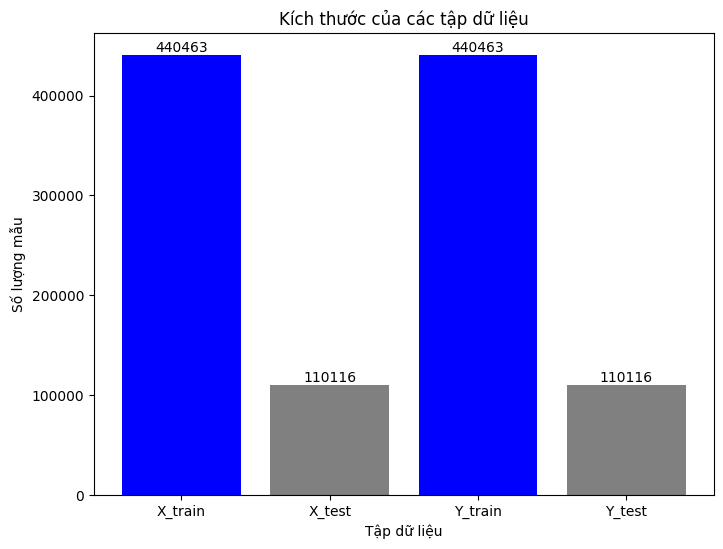

In [ ]:
# Kích thước tập dữ liệu
sizes = [X_train.shape[0], X_test.shape[0], Y_train.shape[0], Y_test.shape[0]]
labels = ['X_train', 'X_test', 'Y_train', 'Y_test']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, sizes, color=['blue', 'grey', 'blue', 'grey'])
plt.xlabel('Tập dữ liệu')
plt.ylabel('Số lượng mẫu')
plt.title('Kích thước của các tập dữ liệu')

# Hiển thị số liệu lên đầu cột
for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(size), ha='center', va='bottom', fontsize=10)

plt.show()

In [ ]:
print(X_train.shape)
print(X_TEST.shape)
print(Y_train.shape)
print(Y_test.shape)

(440463, 30)
(180587, 30)
(440463,)
(110116,)


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_TEST = np.array(X_TEST)
Y_TEST = np.array(Y_TEST)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_TEST = np.reshape(X_TEST, (X_TEST.shape[0], X_TEST.shape[1],1))

In [ ]:
from keras.regularizers import l2
#input_shape = (X_train.shape[1], X_train.shape[2])

model2 = Sequential()

model2.add(Conv1D(64, kernel_size=3, activation='relu', input_shape = (X_train.shape[1], 1)))
model2.add(MaxPool1D(pool_size=2))  # Adjust pool_size
model2.add(Conv1D(128, kernel_size=3, activation='relu'))
model2.add(MaxPool1D(pool_size=2))  # Adjust pool_size
model2.add(Conv1D(256, kernel_size=3, activation='relu'))
model2.add(Flatten())
model2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))  # Change the number of units to 8 for 8 classes

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 6, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 256)            98560     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [ ]:
history4 = model2.fit(X_train,Y_train, batch_size=2048, epochs=20, validation_data=(X_test,Y_test))

Epoch 1/20
216/216 [==============================] - 99s 440ms/step - loss: 0.1958 - accuracy: 0.9889 - val_loss: 0.0271 - val_accuracy: 1.0000
Epoch 2/20
216/216 [==============================] - 93s 431ms/step - loss: 0.0167 - accuracy: 0.9998 - val_loss: 0.0102 - val_accuracy: 0.9999
Epoch 3/20
216/216 [==============================] - 92s 427ms/step - loss: 0.0079 - accuracy: 0.9999 - val_loss: 0.0058 - val_accuracy: 0.9999
Epoch 4/20
216/216 [==============================] - 102s 471ms/step - loss: 0.0049 - accuracy: 0.9999 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 5/20
216/216 [==============================] - 92s 427ms/step - loss: 0.0041 - accuracy: 0.9999 - val_loss: 0.0030 - val_accuracy: 0.9999
Epoch 6/20
216/216 [==============================] - 98s 453ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 0.0024 - val_accuracy: 0.9999
Epoch 7/20
216/216 [==============================] - 98s 454ms/step - loss: 0.0026 - accuracy: 0.9999 - val_loss: 0.0022 - val_a

In [ ]:
model2.save('model_ddos.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Đánh giá trên tập TEST mới
test_results = model2.evaluate(X_TEST, Y_TEST, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

5644/5644 [==============================] - 39s 7ms/step - loss: 29605592.0000 - accuracy: 0.0315
Test results - Loss: 29605592.0 - Accuracy: 3.1475134193897247%


In [ ]:
# Đánh giá trên tập huấn luyện
train_results = model2.evaluate(X_train, Y_train, verbose=1)
print(f'Train results - Loss: {train_results[0]} - Accuracy: {train_results[1]*100}%')

13765/13765 [==============================] - 77s 6ms/step - loss: 0.0011 - accuracy: 1.0000
Train results - Loss: 0.0010833912529051304 - Accuracy: 86.99644267559052%
